### Extreme Event Case Study: October 2007 Santa Ana winds + wildfire

Provide 2-3 sentences on the HDP purpose (victoria to provide)

Provide 2-3 sentences on historical context of the event

In [23]:
# imports
import boto3
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import s3fs
import tempfile  # Used for downloading (and then deleting) netcdfs to local drive from s3 bucket
import os
from shapely.geometry import Point
import time  # Used for progress bar
import sys  # Used for progress bar
from case_study_eval_utils import *


# Set AWS credentials
s3 = boto3.resource("s3")
s3_cl = boto3.client("s3")  # for lower-level processes

# Set relative paths to other folders and objects in repository.
BUCKET_NAME = "wecc-historical-wx"
QAQC_DIR = "3_qaqc_wx"
MERGE_DIR = "4_merge_wx"
stations_csv_path = f"s3://{BUCKET_NAME}/{QAQC_DIR}/all_network_stationlist_qaqc.csv"

## Step 1:

In [2]:
# using google doc for event
# subset all stations for time dates, probably within a 2 week window on either side
# depending on the event, susbet for specific variables (ask Victoria)

In [16]:
# Read in a list of weather stations
# We just use the names of the stations to filter
# Ideally I'd like to see this moved to the AWS bucket
train_stns = pd.read_csv(
    "s3://wecc-historical-wx/4_merge_wx/all_network_stationlist_merge.csv"
)

# Create new geometry column from lat and lon columns
# This will enable us to filter through the GeoDataFrame using our county geometry
train_stns = gpd.GeoDataFrame(
    train_stns,
    geometry=gpd.points_from_xy(
        train_stns.longitude, train_stns.latitude, crs="EPSG:4326"
    ),
)
# train_stns.head()

In [17]:
# Read in county shapefiles from S3
ca_counties = gpd.read_file(
    "s3://wecc-historical-wx/0_maps/ca_counties/CA_Counties.shp"
)
ca_counties = ca_counties.to_crs(train_stns.crs)  # Convert to station CRS
# ca_counties.head()

In [18]:
event_start_date = "2007-10-05"  # Start a few days before the mudslide
event_end_date = "2007-11-30"

event_geom = ca_counties[ca_counties["NAME"] == "San Diego"]  # Get event geometry

In [19]:
train_stns["intersects"] = train_stns.intersects(
    event_geom.unary_union
)  # See which stations intersect with the event polygon
event_stns = train_stns[train_stns["intersects"] == True].reset_index(
    drop=True
)  # Get just those stations, drop the others
event_stns

,Unnamed: 0,era-id,latitude,longitude,elevation,start-date,end-date,pulled,time_checked,network,...,sfcwind_nobs,sfcwind_dir_nobs,rsds_nobs,total_nobs,qaqc,time_qaqc,merged,time_merge,geometry,intersects
0,76,ASOSAWOS_72293193107,32.86700,-117.13300,145.3896,2005-04-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-01-09 16:28:28+00:00,ASOSAWOS,...,174010,131645,0,179796,Y,2025-05-20 16:02:43+00:00,Y,2025-06-12 18:36:24+00:00,POINT (-117.13300 32.86700),True
1,101,ASOSAWOS_74505653120,33.03800,-116.91600,422.1480,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-01-09 16:28:28+00:00,ASOSAWOS,...,206978,113768,0,214563,Y,2025-05-01 19:47:04+00:00,Y,2025-06-12 18:47:36+00:00,POINT (-116.91600 33.03800),True
2,109,ASOSAWOS_72293453121,33.21900,-117.35000,9.1440,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-01-09 16:28:28+00:00,ASOSAWOS,...,194657,108265,0,202377,Y,2025-05-01 19:39:51+00:00,Y,2025-06-12 18:30:06+00:00,POINT (-117.35000 33.21900),True
3,135,ASOSAWOS_72292800369,33.28600,-117.45600,27.1272,2009-10-29 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-01-09 16:28:28+00:00,ASOSAWOS,...,113432,93619,0,123113,Y,2025-05-01 19:37:06+00:00,Y,2025-06-12 18:28:38+00:00,POINT (-117.45600 33.28600),True
4,184,ASOSAWOS_72290303131,32.81500,-117.13700,127.4064,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-01-09 16:28:28+00:00,ASOSAWOS,...,182809,128417,0,189378,Y,2025-05-01 19:38:39+00:00,Y,2025-06-12 18:30:08+00:00,POINT (-117.13700 32.81500),True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,14988,SGXWFO_SDESC,33.11900,-117.09000,645.0000,2010-07-06 00:00:00+00:00,2013-09-12 14:56:00+00:00,Y,2023-03-22 00:06:47+00:00,SGXWFO,...,16936,15461,0,16937,Y,2025-05-02 06:31:49+00:00,Y,2025-06-12 23:27:08+00:00,POINT (-117.09000 33.11900),True
525,14990,SGXWFO_SDL34,33.20970,-117.39500,10.0000,2010-05-05 00:00:00+00:00,2013-09-12 14:56:00+00:00,Y,2023-03-22 00:06:47+00:00,SGXWFO,...,23049,22735,0,23050,Y,2025-05-02 06:32:35+00:00,Y,2025-06-12 23:27:50+00:00,POINT (-117.39500 33.20970),True
526,14991,SGXWFO_F0495,32.76417,-117.22633,22.0000,2010-02-02 00:00:00+00:00,2023-03-08 21:16:00+00:00,Y,2023-03-22 00:06:47+00:00,SGXWFO,...,169181,91092,0,169195,Y,2025-05-02 06:32:33+00:00,Y,2025-06-12 23:28:30+00:00,POINT (-117.22633 32.76417),True
527,14992,SGXWFO_SDMLO,32.84100,-116.42700,6110.0000,2010-04-27 00:00:00+00:00,2017-02-04 07:54:00+00:00,Y,2023-03-22 00:06:47+00:00,SGXWFO,...,52284,45466,0,52285,Y,2025-05-02 06:33:45+00:00,Y,2025-06-12 23:28:59+00:00,POINT (-116.42700 32.84100),True


<AxesSubplot:>

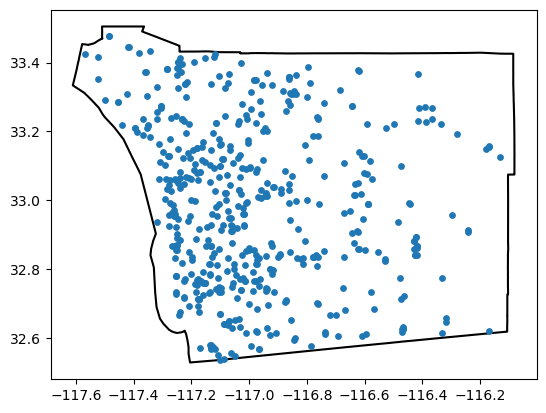

In [9]:
# Make a plot to visualize the stations and event poly
fig, ax = plt.subplots()
event_geom.boundary.plot(color="black", ax=ax, zorder=10)
event_stns.geometry.plot(markersize=15, ax=ax, zorder=15)

In [ ]:
# subset for variables of interest
event_stns.columns
# sfcWind, hurs, pr, pr_24h, pr_1h, pr_5min, pr_localmid

# Victoria
# sfcWind, relative humidity, air temp
# usually massive drop in hum and bump in air temp for stana ana wind events, should see temp going up and hurs staying low even afte wind event has died down
# wind direction also
# should see winds staying low
# winds help push wildfires out, but also put it out
# should see bump in sfcwind

# sum up:
# wind speed, secondarily wind diraction (less), air temp, relative hum
# should see winds rel low, variable, then leading into event see spike in wind speed, fairly unidirectional wind direction from NE to SW, then after wind event has ended, wind speed drops down
# during peak of wind, see bump in tem (and diuran) and plummeting of rh
# as wind event dies, air temp stays high if not approach world records (for wildfire) and rh stay low

# any functions I devleop, make sure methods are consistent, put those functions into the script

# Victoria will start on case study next week


Index(['Unnamed: 0', 'era-id', 'latitude', 'longitude', 'elevation',
       'start-date', 'end-date', 'pulled', 'time_checked', 'network',
       'cleaned', 'time_cleaned', 'tas_nobs', 'tdps_nobs', 'tdps_derived_nobs',
       'ps_nobs', 'ps_derived_nobs', 'psl_nobs', 'ps_altimeter_nobs',
       'pr_nobs', 'pr_5min_nobs', 'pr_1h_nobs', 'pr_24h_nobs',
       'pr_localmid_nobs', 'hurs_nobs', 'sfcwind_nobs', 'sfcwind_dir_nobs',
       'rsds_nobs', 'total_nobs', 'qaqc', 'time_qaqc', 'geometry',
       'intersects'],
      dtype='object')

In [21]:
url = "wecc-historical-wx/4_merge_wx/ASOSAWOS/ASOSAWOS_72293193107.zarr"
ds = xr.open_zarr(url)
#df = ds.to_dataframe()

/tmp/ipykernel_97612/2275319553.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_zarr(url)


GroupNotFoundError: group not found at path ''

In [8]:
event_info("santa_ana_wind","2007-10-05","2007-11-30")

('1988-02-16', '1988-02-19')

## Step 2:

In [ ]:
# produce simple timeseries plots of variable over the event
# include QC flags
# if possible, add shaded bars or something (look at old code) to indicate the event itself

In [11]:
event_stns.head(3)

,Unnamed: 0,era-id,latitude,longitude,elevation,start-date,end-date,pulled,time_checked,network,...,pr_localmid_nobs,hurs_nobs,sfcwind_nobs,sfcwind_dir_nobs,rsds_nobs,total_nobs,qaqc,time_qaqc,geometry,intersects
0,76,ASOSAWOS_72293193107,32.867,-117.133,145.3896,2005-04-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-01-09 16:28:28+00:00,ASOSAWOS,...,0,0,174010,131645,0,179796,Y,2025-05-20 16:02:43+00:00,POINT (-117.13300 32.86700),True
1,101,ASOSAWOS_74505653120,33.038,-116.916,422.1480,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-01-09 16:28:28+00:00,ASOSAWOS,...,0,0,206978,113768,0,214563,Y,2025-05-01 19:47:04+00:00,POINT (-116.91600 33.03800),True
2,109,ASOSAWOS_72293453121,33.219,-117.350,9.1440,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-01-09 16:28:28+00:00,ASOSAWOS,...,0,0,194657,108265,0,202377,Y,2025-05-01 19:39:51+00:00,POINT (-117.35000 33.21900),True


In [ ]:
df = pd.read_csv()

In [ ]:
df.plot(
    ax=ax,
    x="time",
    y=var,
    marker=".",
    ms=4,
    lw=1,
    color="k",
    alpha=0.5,
    label="Cleaned data",
)

## Step 3:

In [ ]:
# some kind of map

In [ ]:
# table / stats "read out" on extremes during the event

In [ ]:
# table / stats "read out" on QC flags, including if we think refinement to QC tests would improve coverage

In [ ]:
# some function/thing in terms of how many stations "detected" the event

In [ ]:
# summary information via markdown close out of what we have learned